# Income Classification

Original Dataset: https://archive.ics.uci.edu/ml/datasets/adult

### Imports

In [441]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import category_encoders as ce
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.discrete.discrete_model import Logit 
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import GridSearchCV

## Preparation

### Load data

In [442]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])

train_df_size = train_df.shape[0]
test_df_size = test_df.shape[0]
df_size = train_df_size + test_df_size

print(f'Train Dataset Size: {train_df_size} ({(train_df_size/df_size):.2%})')
print(f'Test Dataset Size: {test_df_size} ({(test_df_size/df_size):.2%})')

Train Dataset Size: 32561 (66.67%)
Test Dataset Size: 16281 (33.33%)


### Pre Processing

First we need to label the data with ones for income >50k and zeros for income <=50k.

In [443]:
train_df['income'] = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
test_df['income'] = test_df['income'].apply(lambda x: 1 if x == '>50K.' else 0)

**education** is encoded in **education-num** with numbe from 1 to 16. We can also drop this variable, because the information is useless.

In [444]:
train_df = train_df.drop('education-num',axis= 1)
test_df = test_df.drop("education-num", axis = 1)

### Dataset Info

The dataset contains 9 character variables and 6 numerical variables.
**income** is the target variable.

In [445]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  31978 non-null  object
 13  income          32561 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Dataset statistics

### Check missing values and fill it with most recent values

In [446]:
train_df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [447]:
train_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
train_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
train_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

test_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
test_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
test_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

In [448]:
train_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Numeric

In [449]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0
income,32561.0,0.240810,0.427581,0.0,0.0,0.0,0.0,1.0


## Variables

In [450]:
categorical = [var for var in train_df.columns if train_df[var].dtype==object]
numeric = [var for var in train_df.columns if train_df[var].dtype!=object]
numeric.remove("income")

print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(train_df[var].unique())} labels')

print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels

There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# Charts

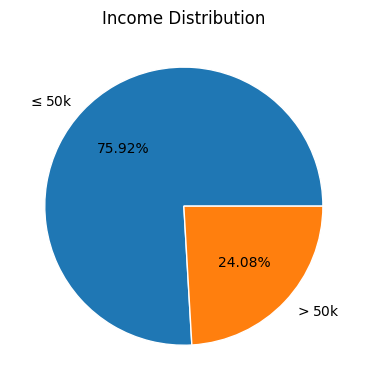

In [451]:
plt.figure(figsize=(4,4))
train_df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.show()

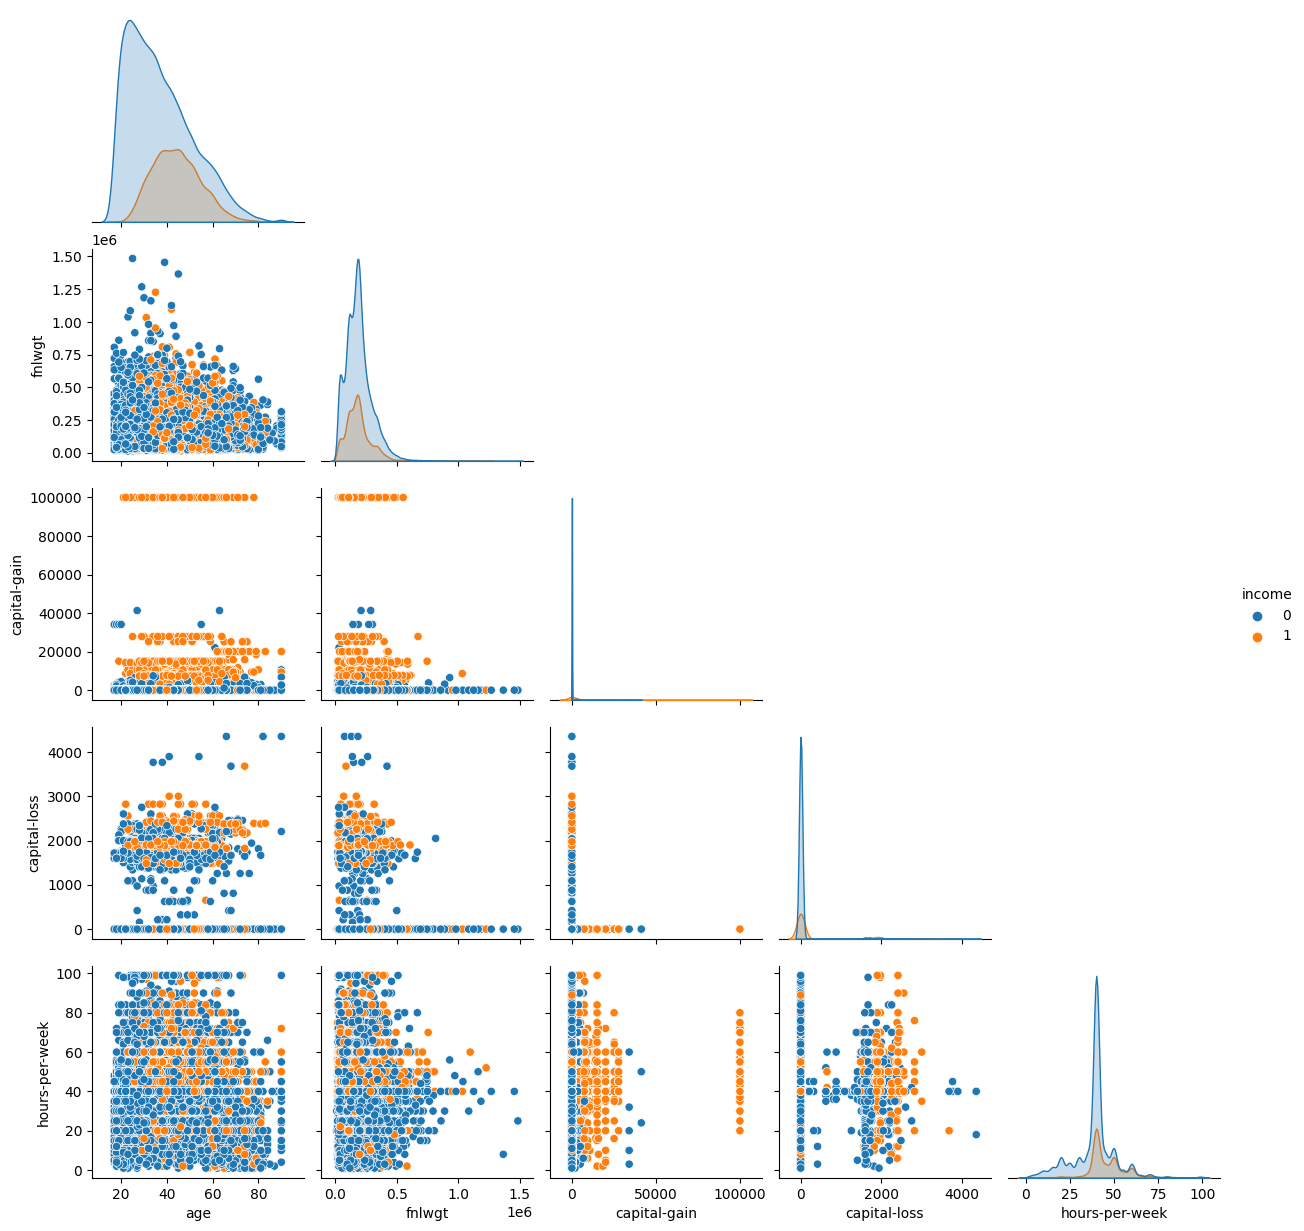

In [452]:
sns.pairplot(train_df.drop(categorical, axis=1), hue='income', corner=True)
plt.show()

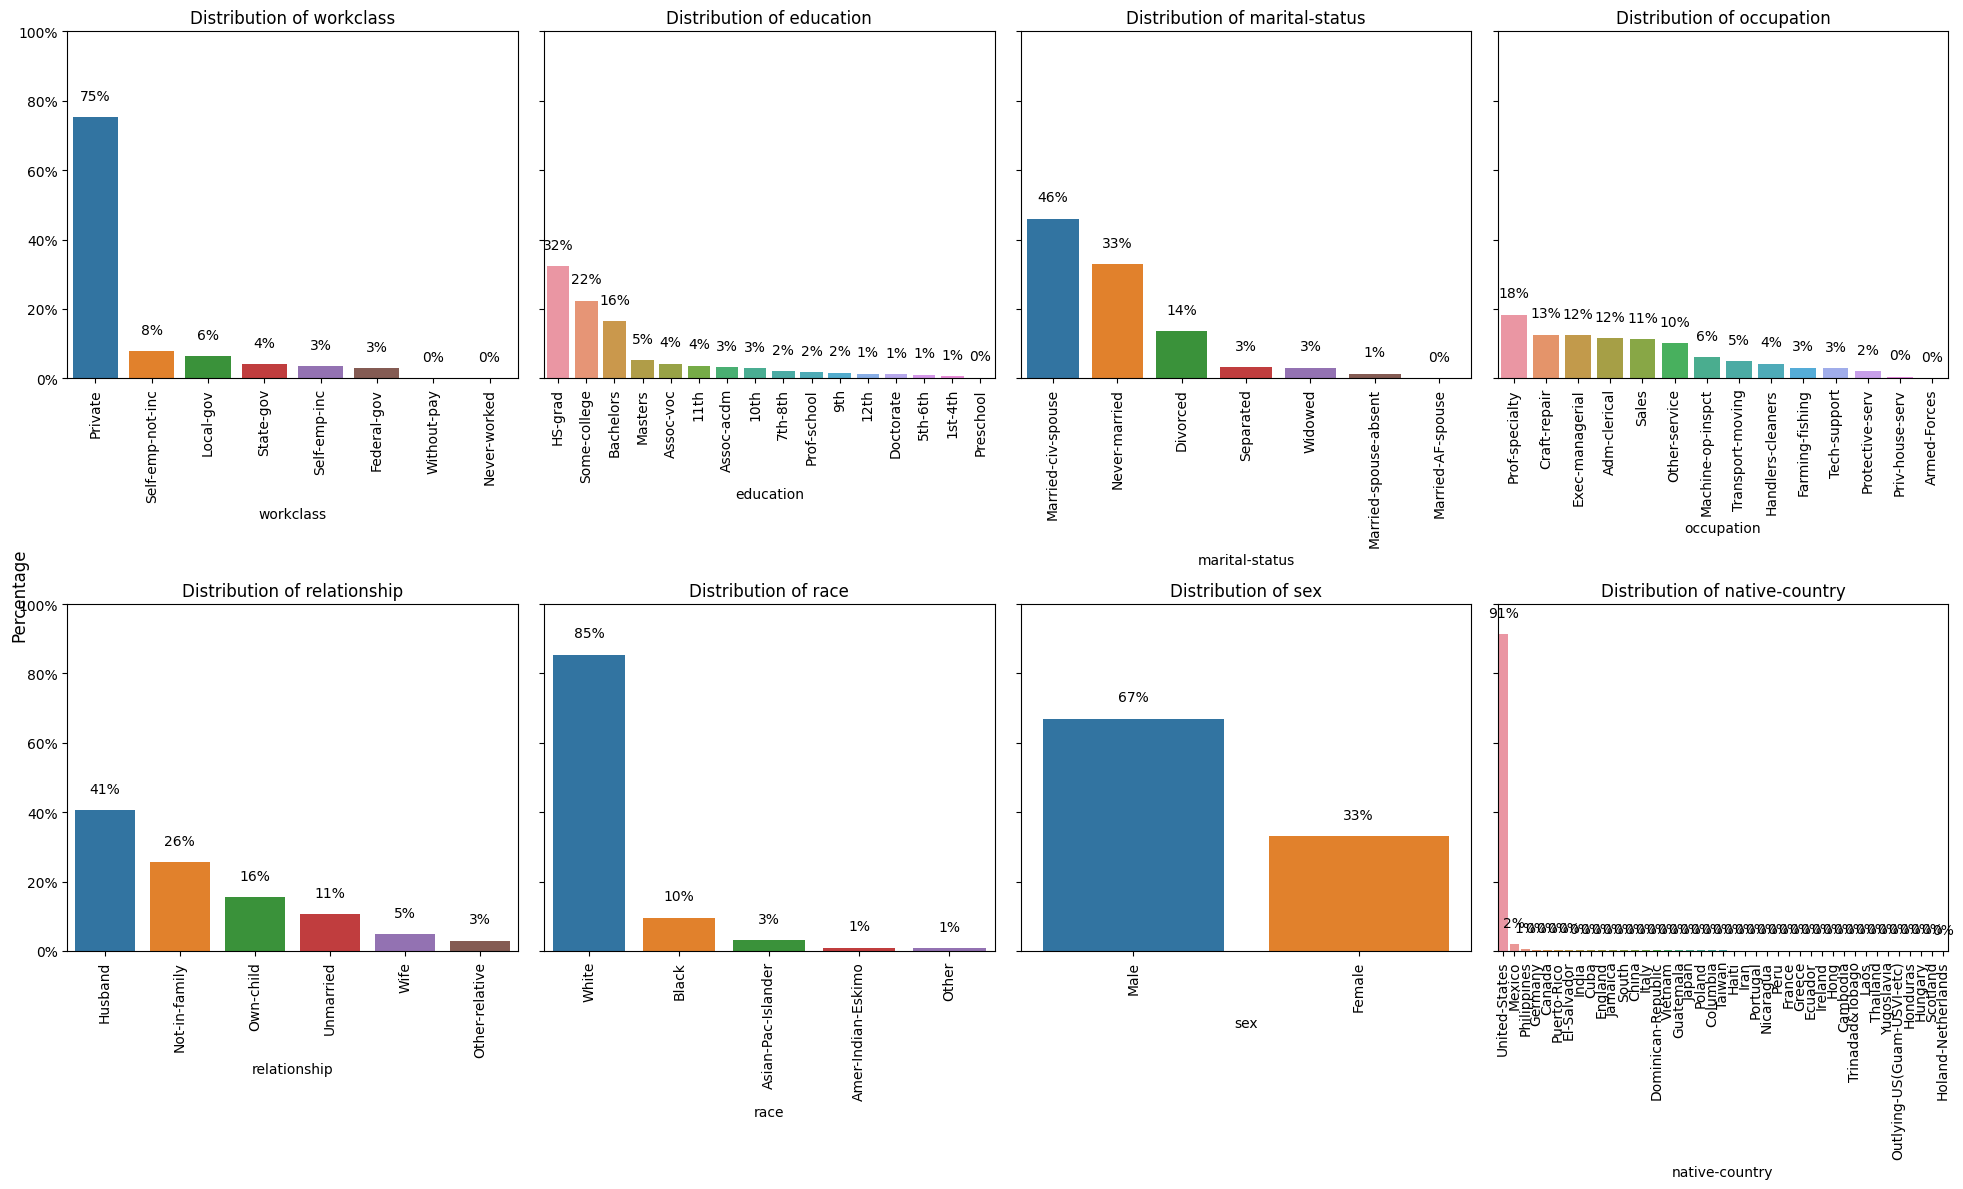

In [453]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = train_df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.show()

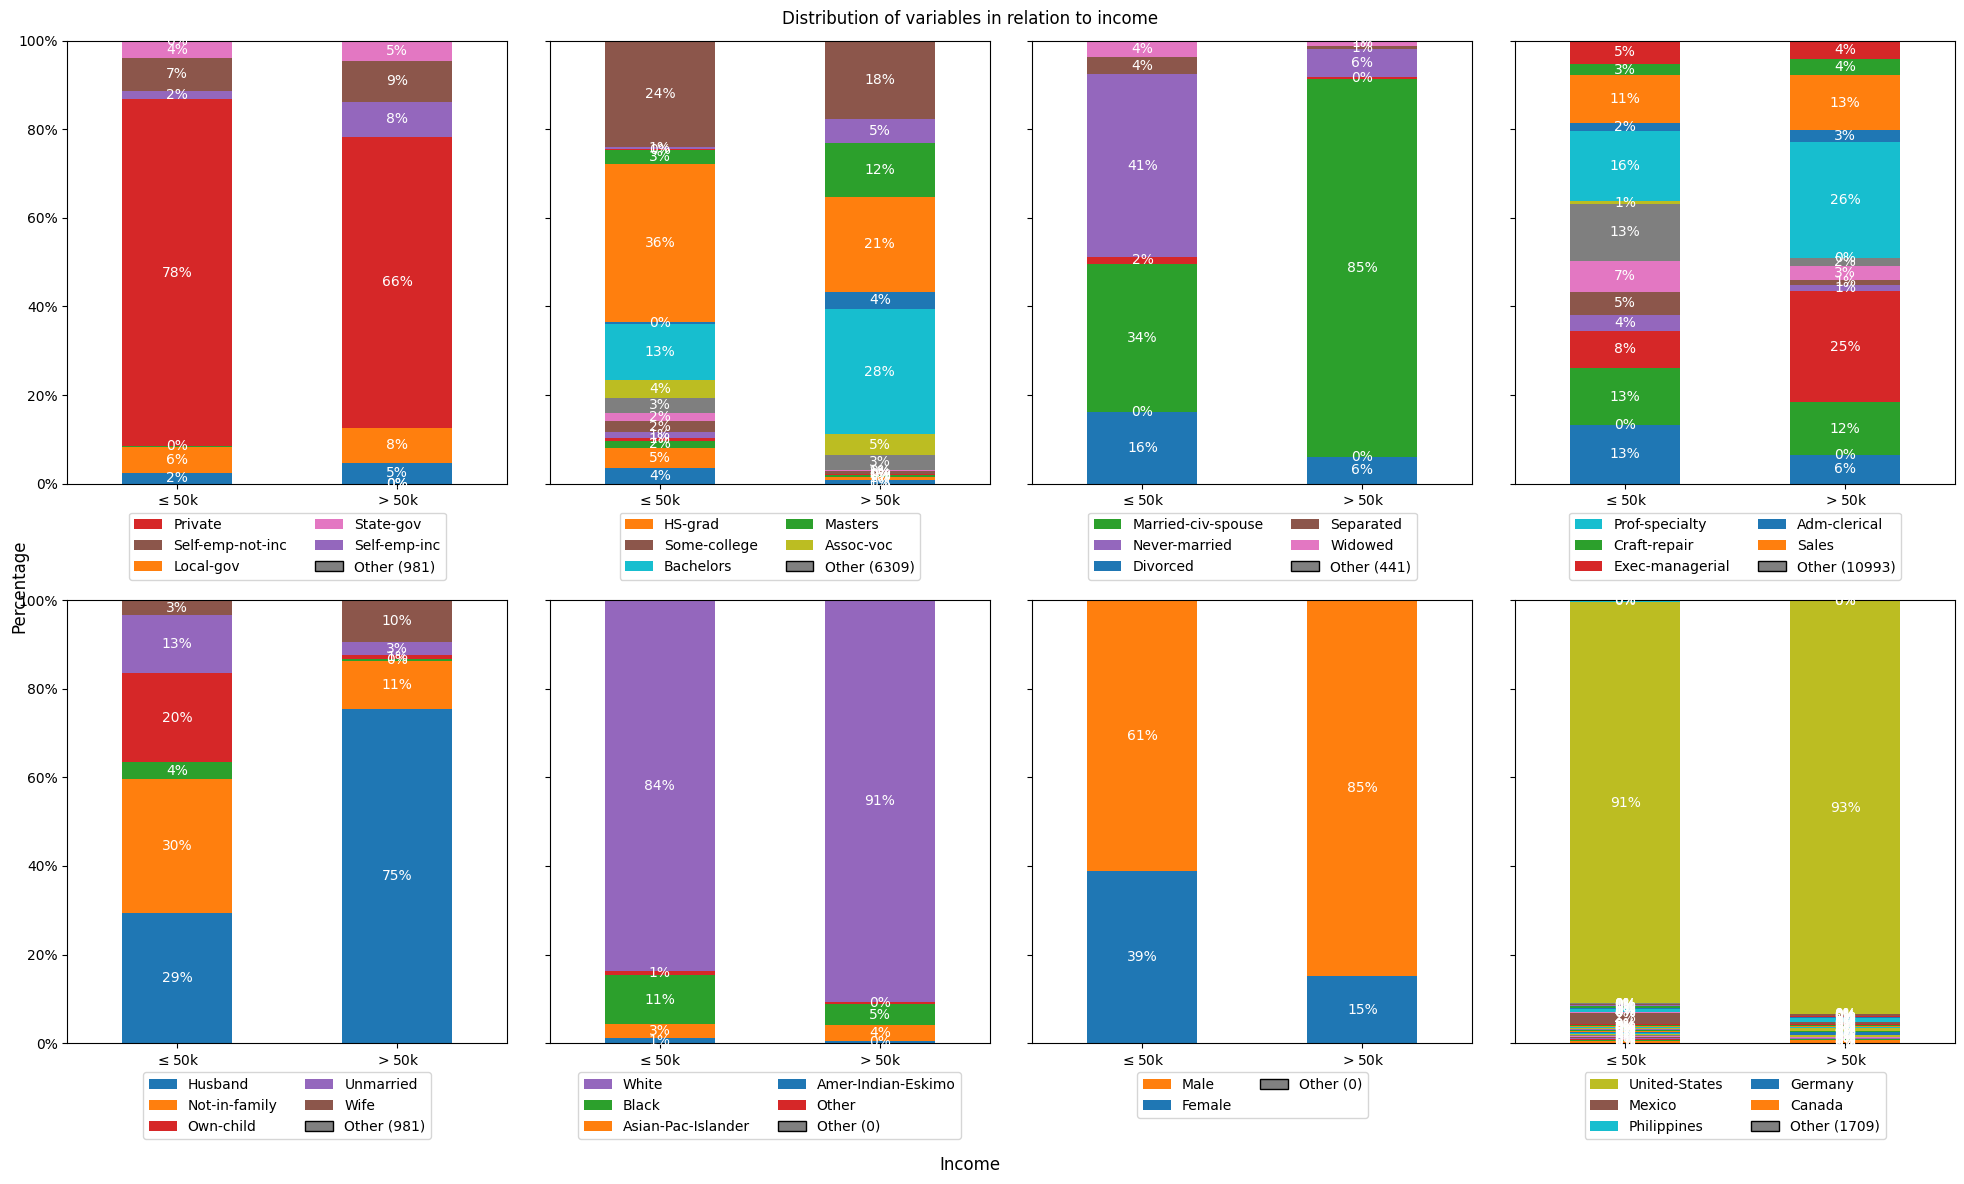

In [454]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(train_df['income'], train_df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.show()

In [455]:
print('Race')
print('-----------')
race_counts = train_df.groupby('race')['income'].value_counts().unstack()
print(race_counts)

train_df = train_df.drop('race',axis= 1)
test_df = test_df.drop("race", axis = 1)
categorical.remove('race')

Race
-----------
income                  0     1
race                           
Amer-Indian-Eskimo    275    36
Asian-Pac-Islander    763   276
Black                2737   387
Other                 246    25
White               20699  7117


In [456]:
print('Occupation')
print('-----------')
occupation_counts = train_df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)

old_labels = ["Adm-clerical", "Armed-Forces", "Craft-repair", "Farming-fishing", "Handlers-cleaners", "Machine-op-inspct", "Priv-house-serv", "Protective-serv", "Transport-moving"]
new_label = "blue" # handwerk

train_df.loc[train_df["occupation"].isin(old_labels), "occupation"] = new_label
test_df.loc[test_df["occupation"].isin(old_labels), "occupation"] = new_label

old_labels = ["Exec-managerial", "Other-service", "Prof-specialty", "Sales", "Tech-support"]
new_label = "white" # büro

train_df.loc[train_df["occupation"].isin(old_labels), "occupation"] = new_label
test_df.loc[test_df["occupation"].isin(old_labels), "occupation"] = new_label

print('Occupation')
print('-----------')
occupation_counts = train_df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)


Occupation
-----------
income                0     1
occupation                   
Adm-clerical       3263   507
Armed-Forces          8     1
Craft-repair       3170   929
Exec-managerial    2098  1968
Farming-fishing     879   115
Handlers-cleaners  1284    86
Machine-op-inspct  1752   250
Other-service      3158   137
Priv-house-serv     148     1
Prof-specialty     3933  2050
Protective-serv     438   211
Sales              2667   983
Tech-support        645   283
Transport-moving   1277   320
Occupation
-----------
income          0     1
occupation             
blue        12219  2420
white       12501  5421


In [457]:
print('Education')
print('-----------')
education_counts = train_df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

old_labels = ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th"]
new_label = "Pre-Highschool"

train_df.loc[train_df["education"].isin(old_labels), "education"] = new_label
test_df.loc[test_df["education"].isin(old_labels), "education"] = new_label

old_labels = ["Bachelors", "Masters", "Doctorate", "Assoc-acdm", "Assoc-voc", "Prof-school", "Some-college"]
new_label = "Academic"

train_df.loc[train_df["education"].isin(old_labels), "education"] = new_label
test_df.loc[test_df["education"].isin(old_labels), "education"] = new_label

print('Education (modified)')
print('-----------')

education_counts = train_df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

Education
-----------
income             0       1
education                   
10th           871.0    62.0
11th          1115.0    60.0
12th           400.0    33.0
1st-4th        162.0     6.0
5th-6th        317.0    16.0
7th-8th        606.0    40.0
9th            487.0    27.0
Assoc-acdm     802.0   265.0
Assoc-voc     1021.0   361.0
Bachelors     3134.0  2221.0
Doctorate      107.0   306.0
HS-grad       8826.0  1675.0
Masters        764.0   959.0
Preschool       51.0     0.0
Prof-school    153.0   423.0
Some-college  5904.0  1387.0
Education (modified)
-----------
income              0     1
education                  
Academic        11885  5922
HS-grad          8826  1675
Pre-Highschool   4009   244


In [458]:
print('Workclass')
print('-----------')
workclass_counts = train_df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

train_df = train_df.drop(train_df[train_df['workclass'] == 'Never-worked'].index)
train_df = train_df.drop(train_df[train_df['workclass'] == 'Without-pay'].index)

test_df = test_df.drop(train_df[train_df['workclass'] == 'Never-worked'].index)
test_df = test_df.drop(train_df[train_df['workclass'] == 'Without-pay'].index)

old_labels = ["Federal-gov", "Local-gov", "State-gov"]
new_label = "Gov"

train_df.loc[train_df["workclass"].isin(old_labels), "workclass"] = new_label
test_df.loc[test_df["workclass"].isin(old_labels), "workclass"] = new_label

print('Workclass (modified)')
print('-----------')
workclass_counts = train_df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

Workclass
-----------
income                  0       1
workclass                        
Federal-gov         589.0   371.0
Local-gov          1476.0   617.0
Never-worked          7.0     0.0
Private           19378.0  5154.0
Self-emp-inc        494.0   622.0
Self-emp-not-inc   1817.0   724.0
State-gov           945.0   353.0
Without-pay          14.0     0.0
Workclass (modified)
-----------
income                0     1
workclass                    
Gov                3010  1341
Private           19378  5154
Self-emp-inc        494   622
Self-emp-not-inc   1817   724


In [459]:
print('Relationship')
print('-----------')
relationship_counts = train_df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

old_labels = ["Husband", "Wife"]
new_label = "Married"

train_df.loc[train_df["relationship"].isin(old_labels), "relationship"] = new_label
test_df.loc[test_df["relationship"].isin(old_labels), "relationship"] = new_label

print('Relationship (modified)')
print('-----------')
relationship_counts = train_df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

Relationship
-----------
income             0     1
relationship              
Husband         7271  5918
Not-in-family   7448   856
Other-relative   944    37
Own-child       4991    67
Unmarried       3226   218
Wife             819   745
Relationship (modified)
-----------
income             0     1
relationship              
Married         8090  6663
Not-in-family   7448   856
Other-relative   944    37
Own-child       4991    67
Unmarried       3226   218


In [460]:
print('Sex')
print('-----------')
sex_counts = train_df.groupby('sex')['income'].value_counts().unstack().fillna(0)
print(sex_counts)

Sex
-----------
income      0     1
sex                
Female   9585  1179
Male    15114  6662


In [461]:
print('Marital Status')
print('-----------')
marital_counts = train_df.groupby('marital-status')['income'].value_counts().unstack().fillna(0)
print(marital_counts)

train_df = train_df.drop('marital-status',axis= 1)
test_df = test_df.drop("marital-status", axis = 1)
categorical.remove('marital-status')


Marital Status
-----------
income                     0     1
marital-status                    
Divorced                3979   463
Married-AF-spouse         13    10
Married-civ-spouse      8275  6692
Married-spouse-absent    383    34
Never-married          10183   491
Separated                959    66
Widowed                  907    85


In [462]:
print('Native Country')
print('-----------')
native_country_counts = train_df.groupby('native-country')['income'].value_counts().unstack().fillna(0)
print(native_country_counts)

train_df = train_df.drop('native-country',axis= 1)
test_df = test_df.drop("native-country", axis = 1)
categorical.remove('native-country')

Native Country
-----------
income                            0       1
native-country                             
Cambodia                       12.0     7.0
Canada                         82.0    39.0
China                          55.0    20.0
Columbia                       57.0     2.0
Cuba                           70.0    25.0
Dominican-Republic             68.0     2.0
Ecuador                        24.0     4.0
El-Salvador                    97.0     9.0
England                        60.0    30.0
France                         17.0    12.0
Germany                        93.0    44.0
Greece                         21.0     8.0
Guatemala                      61.0     3.0
Haiti                          40.0     4.0
Holand-Netherlands              1.0     0.0
Honduras                       12.0     1.0
Hong                           14.0     6.0
Hungary                        10.0     3.0
India                          60.0    40.0
Iran                           25.0    18.0
Irela

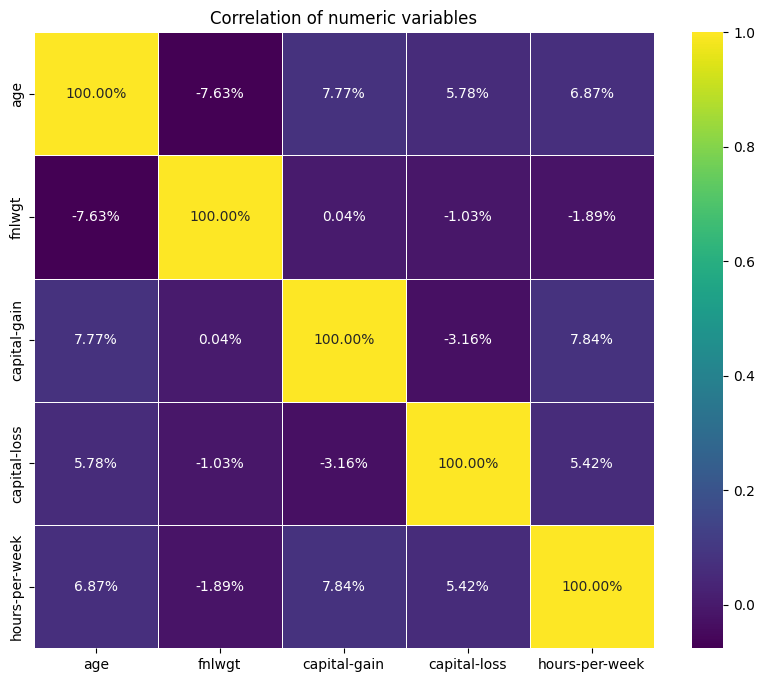

In [463]:
plt.figure(figsize=(10,8), dpi=100)
sns.heatmap(train_df[numeric].corr(), cmap="viridis", fmt=".2%",linewidth=0.5, annot=True)
plt.title("Correlation of numeric variables")
plt.show()

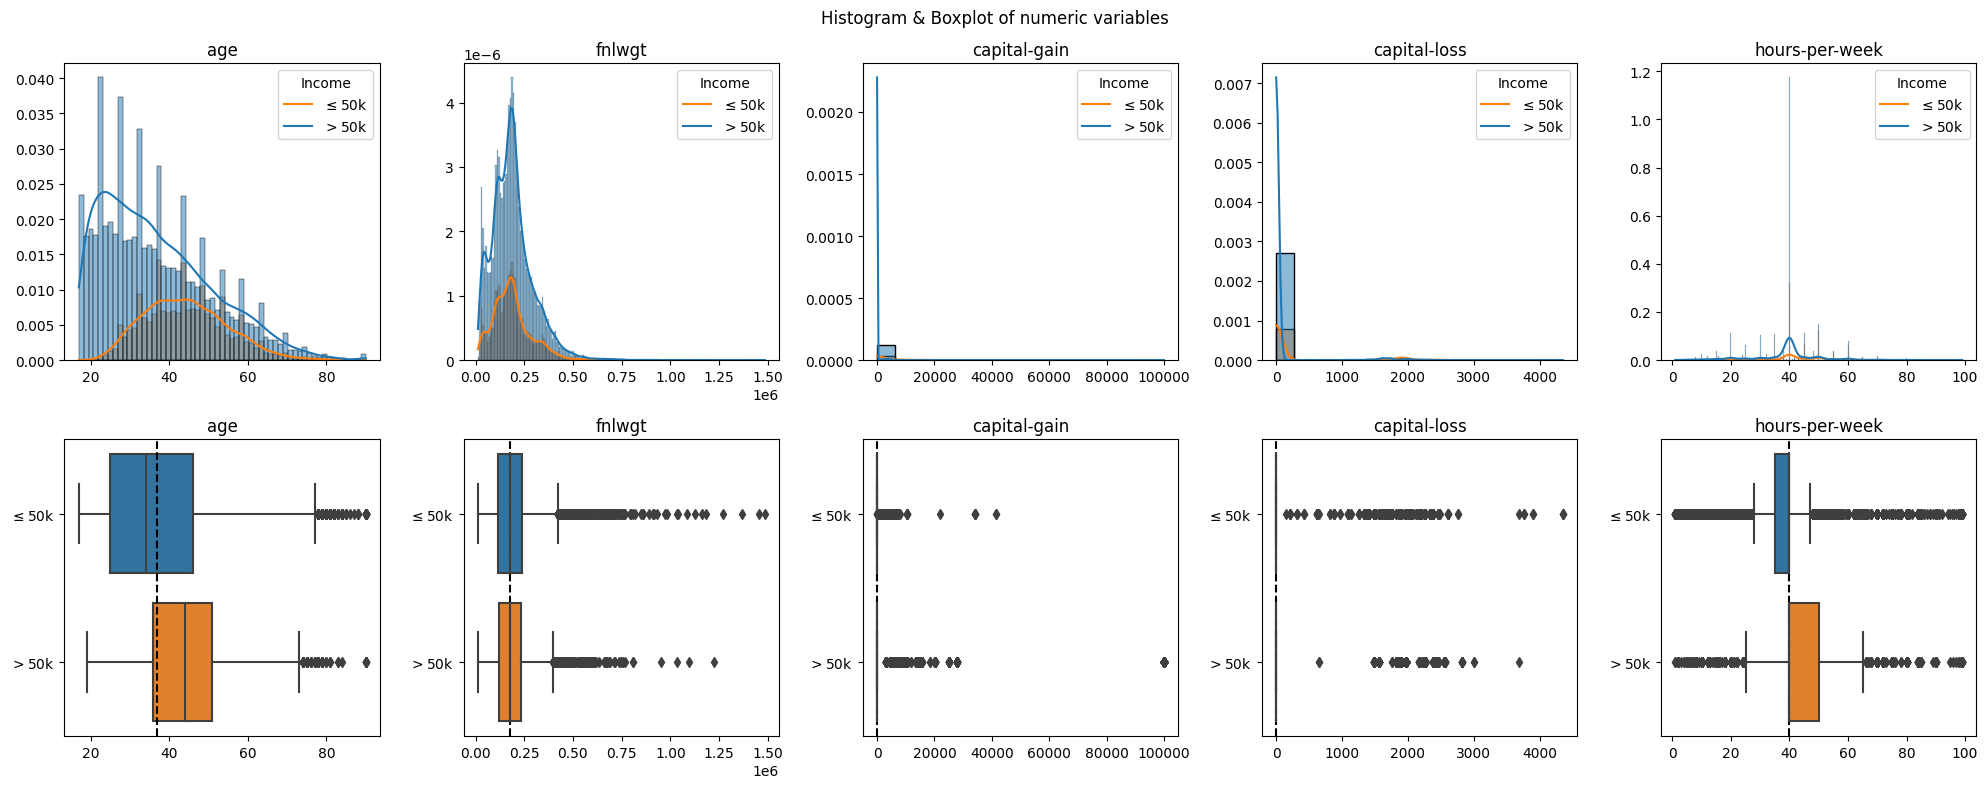

In [464]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=train_df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=train_df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$\leq50$k', '$>50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = train_df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.show()

In [465]:
train_df.drop(categorical, axis=1)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,income
0,39,77516,2174,0,40,0
1,50,83311,0,0,13,0
2,38,215646,0,0,40,0
3,53,234721,0,0,40,0
4,28,338409,0,0,40,0
...,...,...,...,...,...,...
32556,27,257302,0,0,38,0
32557,40,154374,0,0,40,1
32558,58,151910,0,0,40,0
32559,22,201490,0,0,20,0


## Results


- We can encode **sex** to a binary variable
- encode all categorical variables
- age and fnlwgt looks like they can be logarithmically transformed

In [466]:
print(f'Train Shape before encoding: {train_df.shape}')
print(f'Test Shape before encoding: {test_df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
train_df = onehot_encoder.fit_transform(train_df)
test_df = onehot_encoder.transform(test_df)

print(f'Train Shape after encoding: {train_df.shape}')
print(f'Test Shape after encoding: {test_df.shape}')

train_df.head()

Train Shape before encoding: (32540, 11)
Test Shape before encoding: (16281, 11)
Train Shape after encoding: (32540, 22)
Test Shape after encoding: (16281, 22)


,age,workclass_1,workclass_2,workclass_3,workclass_4,fnlwgt,education_1,education_2,education_3,occupation_1,...,relationship_2,relationship_3,relationship_4,relationship_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,income
0,39,1,0,0,0,77516,1,0,0,1,...,0,0,0,0,1,0,2174,0,40,0
1,50,0,1,0,0,83311,1,0,0,0,...,1,0,0,0,1,0,0,0,13,0
2,38,0,0,1,0,215646,0,1,0,1,...,0,0,0,0,1,0,0,0,40,0
3,53,0,0,1,0,234721,0,0,1,1,...,1,0,0,0,1,0,0,0,40,0
4,28,0,0,1,0,338409,1,0,0,0,...,1,0,0,0,0,1,0,0,40,0


# Principal component analysis (PCA)

### Notizen
Wieso Dimensions Reduktion?
1. Menschen können sich sehr schwer vorstellen wie höhere Dimensionen aussehen / auch schwer zu Visualisieren
2. Man benötigt sehr viel computing power um ML Algorithmen mit vielen Dimensionen zu trainieren
3. ML-Modelle basierend auf sehr vielen Dimensionen werden ungenau

https://setosa.io/ev/principal-component-analysis/
Was ist und macht PCA?

- PCA führt zu einem guten Verständnis der Daten
- Zur Entscheidung wie viele Hauptkomponenten gewählt werden kmodel man sich der erklärten Varianz zu nutze machen. (Proportion of variance explained PVE)
- Sie kmodel auch als Hilfsmittel für das überwachte Lernen vorgeschalten werden
- Vor der PCA sollte man alle Variable skalieren damit Sie alle die Varianz 1 besitzen und somit besser zueinander in Relation stehen

Wie ist das vorgehen bei der PCA?
1. Standardisieren / Skalieren
2. Kovarianzmatrix berechnen
3. Eigenwerte und Eigenvektoren berechnen
4. Egenwerte und -vektoren sortieren (diejenigen mit den höchsten Werten haben die höchste Signifikanz)
5. Transform the original matrix of data by multiplying it top n eigenvectors selected above.

Oder Sklearn PCA



In [467]:
scaler = MinMaxScaler()

pca_train_df = train_df.drop(['income'], axis=1)
pca_test_df = test_df.drop(['income'], axis=1)

#Nur auf trainingsdaten fitten
pca_train_df_scale = scaler.fit_transform(pca_train_df)
pca_test_df_scale = scaler.fit_transform(pca_test_df)

In [468]:
pca2 = PCA(n_components = 2)
principalComponents = pca2.fit_transform(pca_train_df_scale)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train_df[['income']]], axis=1)
finalDf.head()

,principal component 1,principal component 2,income
0,-0.290039,-0.059387,0.0
1,0.131980,-1.274079,0.0
2,-0.859707,0.806534,0.0
3,-1.110363,-0.014803,0.0
4,0.944527,-0.254297,0.0


In [469]:
print('\nDescription')
print(finalDf.describe())
print('\nInfo')
print(finalDf.info())


Description
       principal component 1  principal component 2        income
count           3.254000e+04           3.254000e+04  32540.000000
mean            1.746878e-18          -2.511138e-17      0.240965
std             7.921829e-01           7.339336e-01      0.427676
min            -1.368167e+00          -1.321734e+00      0.000000
25%            -7.506895e-01          -5.159810e-01      0.000000
50%             1.445643e-01           9.566871e-02      0.000000
75%             5.947754e-01           5.397273e-01      0.000000
max             1.421663e+00           1.625472e+00      1.000000

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  32540 non-null  float64
 1   principal component 2  32540 non-null  float64
 2   income                 32540 non-null  float64
dtypes: float64(3)


Text(0, 0.5, 'pc2')

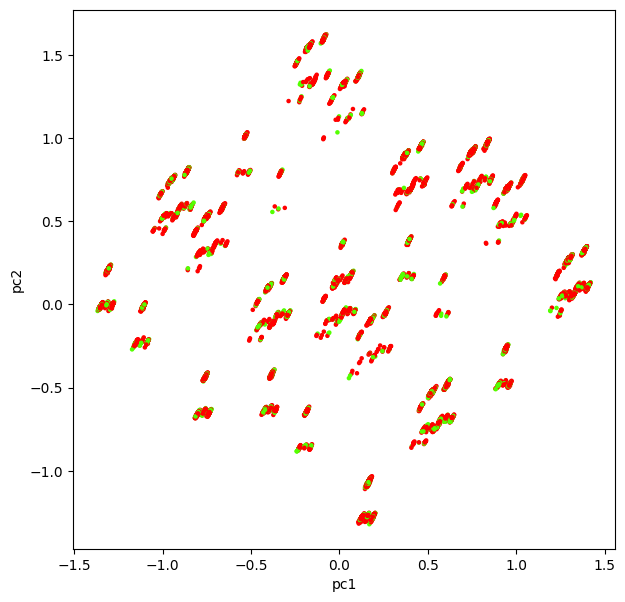

In [470]:
plt.figure(figsize=(7,7))
plt.scatter(finalDf['principal component 1'],finalDf['principal component 2'],c=finalDf['income'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')

In [471]:
#n von pca ist immer die anzahl an variablen
pca = PCA()

principalComponents = pca.fit_transform(pca_train_df_scale)   

# principalComponents = pca.fit(pca_train_df_scale)

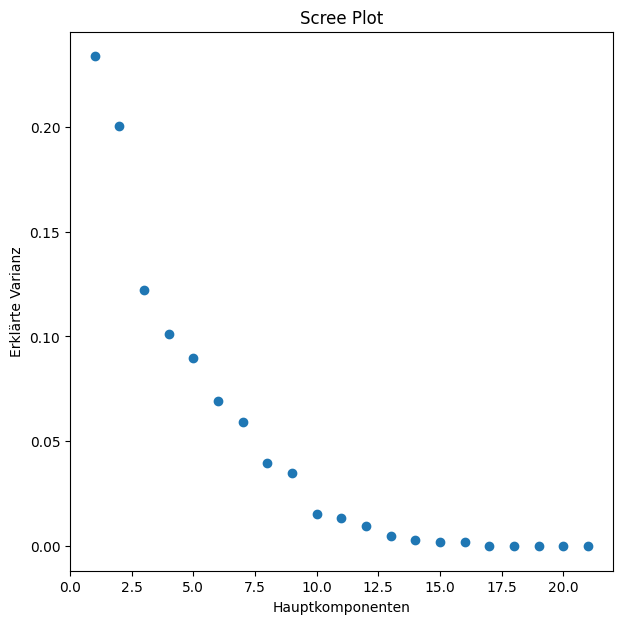

In [472]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca.n_components_) + 1
plt.scatter(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()

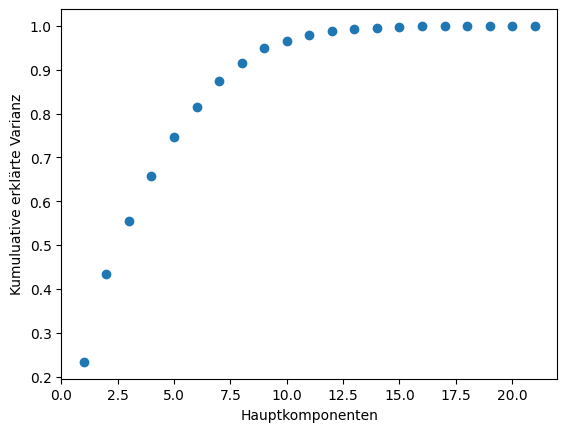

In [473]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [540]:
pca_new = PCA(n_components=10)
pca_new_components = pca_new.fit_transform(pca_train_df_scale)

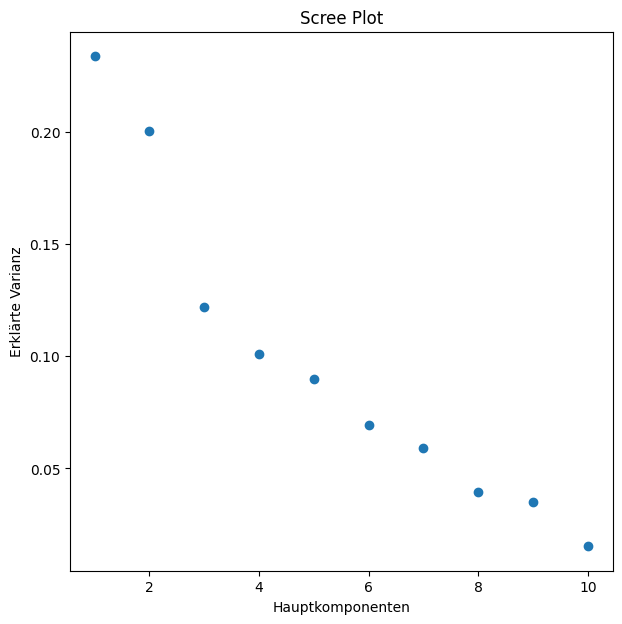

In [475]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca_new.n_components_) + 1
plt.scatter(PC_values, pca_new.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()

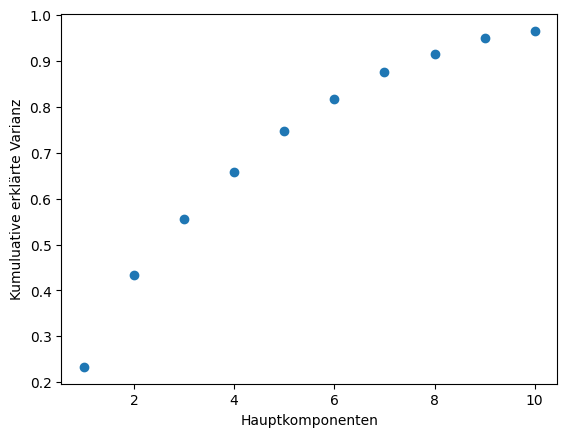

In [476]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca_new.explained_variance_ratio_))
plt.show()

# Cluster Analyse

Was machen Sachen?

# Final Data 

In [477]:
X_train = train_df.drop(["income"],axis=1)
Y_train = train_df['income']

X_test = test_df.drop(["income"],axis=1)
Y_test = test_df['income']

scaler_logit = MinMaxScaler()

# #Nur auf trainingsdaten fitten
x_train_scale = scaler_logit.fit(X_train)

x_train_scale = pd.DataFrame(scaler_logit.transform(X_train), columns=X_train.columns)
x_test_scale = pd.DataFrame(scaler_logit.transform(X_test), columns=X_test.columns)

# Logit-Modell

In [525]:
model = Logit(Y_train, X_train).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.341047
         Iterations 9


In [526]:
model.mle_retvals

{'fopt': 0.3410471283340781,
 'iterations': 9,
 'score': array([-4.10516393e-17, -5.59546945e-19,  4.36719567e-19, -5.45899459e-19,
        -9.55324053e-19,  6.88689289e-14, -1.77417324e-18,  1.09179892e-19,
        -2.45654757e-19, -2.51113751e-18,  7.64259243e-19,  1.11909389e-18,
        -2.73290917e-18,  3.95777108e-19,  1.33745367e-18,  3.00244702e-19,
        -8.18849188e-19,  3.27539675e-18,  8.94401674e-16,  1.11800209e-16,
         4.71657133e-17]),
 'Hessian': array([[-2.13171808e+02, -7.68162071e-01, -4.84282719e-01,
         -3.13287888e+00, -2.35971562e-01, -8.55866654e+05,
         -2.95697920e+00, -1.38182775e+00, -2.82488288e-01,
         -1.82793834e+00, -2.79335690e+00, -7.24333883e-01,
         -3.59981593e+00, -4.93071307e-02, -2.14977433e-01,
         -3.28608570e-02, -3.73853091e+00, -8.82764322e-01,
         -2.06609561e+03, -5.71735344e+02, -1.98561065e+02],
        [-7.68162071e-01, -1.76818703e-02, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -3

In [527]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                32540
Model:                          Logit   Df Residuals:                    32523
Method:                           MLE   Df Model:                           16
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.3824
Time:                        14:54:57   Log-Likelihood:                -11098.
converged:                       True   LL-Null:                       -17968.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0247      0.001     17.015      0.000       0.022       0.028
workclass_1       -0.5961    7.2e+05  -8.27e-07      1.000   -1.41e+06    1.41e+06
workclass_2       -1.2947   7.05e+05

In [528]:
yHat = model.predict(X_test)

In [529]:
prediction = list(map(round, yHat))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction)

Actual values [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

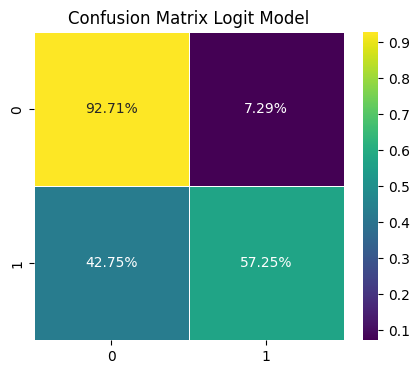

Test accuracy = 84.34 %


In [530]:
# confusion matrix
cm = confusion_matrix(Y_test, prediction) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True)
plt.title("Confusion Matrix Logit Model")
plt.show()

print(f'Test accuracy = {accuracy_score(Y_test, prediction).round(4)*100} %')

In [545]:
model_scaled = Logit(Y_train, pca_new_components).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.581577
         Iterations 6


In [546]:
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                32540
Model:                          Logit   Df Residuals:                    32530
Method:                           MLE   Df Model:                            9
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                -0.05322
Time:                        15:00:02   Log-Likelihood:                -18925.
converged:                       True   LL-Null:                       -17968.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0890      0.015     -5.957      0.000      -0.118      -0.060
x2            -1.2444      0.019    -66.000      0.000      -1.281      -1.207
x3            -0.0342      0.021     -1.603      0.109      -0.076       0.008
x4             0.4813      0.024     20.117      0.000       0.434       0.528
x5            -0.4520      0.025    -18.280      0.000      -0.501      -0.404
x6            -0.9061      0.030    -30.475      0.000      -0.964      -0.848
x7            -0.1368      0.032     -4.333      0.000      -0.199      -0.075
x8            -0.2380      0.038     -6.320      0.000      -0.312      -0.164
x9            -0.2049      0.040     -5.085      0.000      -0.284      -0.126
x10            0.9507      0.077     12.417      0.000       0.801       1.101
==============================================================================
"""

In [551]:
y_hat_scaled = model_scaled.predict(pca_test_df_scale)

ValueError: shapes (16281,21) and (10,) not aligned: 21 (dim 1) != 10 (dim 0)

In [ ]:
prediction2 = list(map(round, y_hat_scaled))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction2)

In [ ]:
cm2 = confusion_matrix(Y_test, prediction2) 
cmn2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn2, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True)
plt.title("Confusion Matrix Logit Model Scaled")
plt.show()
  
# accuracy score of the model
print(f'Test accuracy = {accuracy_score(Y_test, prediction2).round(4)*100} %')

## Logarithmic transformation

In [531]:
X_train['age']  = np.log(X_train['age'])
X_train['fnlwgt']  = np.log(X_train['fnlwgt'])

In [532]:
model_transformed = Logit(Y_train, X_train).fit_regularized()

/Users/simonsymhoven/Uni/master/multivariate-analysemethoden/income-classification/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/simonsymhoven/Uni/master/multivariate-analysemethoden/income-classification/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.33855052834295424
            Iterations: 110
            Function evaluations: 127
            Gradient evaluations: 110


In [ ]:
model_transformed.summary2()

In [ ]:
yhat_transformed = model_transformed.predict(X_test)
prediction_transformed = list(map(round, yhat_transformed))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction_transformed)

In [ ]:
cm3 = confusion_matrix(Y_test, prediction_transformed) 
cmn3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn3, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True)
plt.title("Confusion Matrix Logit Model Log Transformed")
plt.show()
  
# accuracy score of the model
print(f'Test accuracy = {accuracy_score(Y_test, prediction_transformed).round(4)*100} %')

### Vielleicht hier nochmal Parameter Tuning machen mit einem for loop bei verschiedenen n

# Random Forest

In [ ]:
forest = rfc()
forest.fit(x_train_scale,Y_train)


In [ ]:
y_rfc_hat = forest.predict(x_train_scale)

In [ ]:
print(forest.score(x_train_scale,Y_train))
print(forest.score(x_test_scale,Y_test))

In [ ]:
pd.DataFrame(forest.feature_importances_, index=x_train_scale.columns).sort_values(by=0, ascending=False)

### Tuning


In [ ]:
forest_2 = rfc(n_estimators=1000)
forest_2.fit(x_train_scale,Y_train)

In [ ]:
y_rfc_hat_2 = forest_2.predict(x_train_scale)

In [ ]:
print(forest_2.score(x_train_scale,Y_train))
print(forest_2.score(x_test_scale,Y_test))

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 30, 40]
}
forest_tuned = rfc()


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = forest_tuned, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
'''

Muss nochmal verbessert werden bitte nicht löschen!

'''
# # Fit the grid search to the data
# grid_search.fit(x_pca_train, Y_train)
# grid_search.best_params_
# {'bootstrap': True,
#  'max_depth': 80,
#  'max_features': 3,
#  'min_samples_leaf': 5,
#  'min_samples_split': 12,
#  'n_estimators': 100}
# best_grid = grid_search.best_estimator_
# # grid_accuracy = evaluate(best_grid, x_pca_test, Y_test)
# # improvement =  100 * (grid_accuracy - base_accuracy) / base_accuracy
# # print('Improvement of {:0.2f}%.'.format(improvement))

# Neuronal Networks

In [ ]:
model = tf.keras.models.Sequential() # Initializing
model.add(tf.keras.layers.Dense(units=64, activation='relu')) # 2nd hidden layer
model.add(tf.keras.layers.Dense(units=32, activation='relu')) # 2nd hidden layer
model.add(tf.keras.layers.Dense(units=2, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # output layer
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # compiling, there are couple of methods
history = model.fit(x_train_scale, Y_train, validation_split=0.1, batch_size = 16, epochs = 15)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()